In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  2.0.1
Torchvision Version:  0.15.2


# Source

This [tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

# Functions

## Init the model

In [2]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        # model_ft = models.resnet50(pretrained=use_pretrained)
        model_ft = models.resnet152(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

## Train the model

In [3]:
def unfreeze_layers_and_update_optimizer(model, layers_to_unfreeze, optimizer, learning_rate):
    """Freeze all but the specified layers of the model and return updated optimizer"""
    
    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Initialize params_to_update
    params_to_update = []

    # Unfreeze the specified layers
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_unfreeze):
            if '.bn' in name:
                print(f'not unfreezing: {name}')
                continue
            print(f'unfreezing: {name}')
            param.requires_grad = True
            params_to_update.append(param)

    # Update the optimizer
    optimizer = type(optimizer)(params_to_update, lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=learning_rate, max_lr=learning_rate * 10, cycle_momentum=False)

    return optimizer, scheduler


def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, is_inception=False):
    since = time.time()

    # initialize lists to store accuracy and loss values
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    layers_to_unfreeze = ['fc']
    learning_rate = 0.005
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    optimizer, scheduler = unfreeze_layers_and_update_optimizer(model, layers_to_unfreeze, optimizer, learning_rate)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Freeze all but the last layer for the second half of training
        if epoch == num_epochs // 5:
            print('fine tuning starts!,  epoch == num_epochs // 5')
            layers_to_unfreeze = [
                'fc',
                'layer4.2',
            ]
            optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
            learning_rate = 0.001

            optimizer, scheduler = unfreeze_layers_and_update_optimizer(model, layers_to_unfreeze, optimizer, learning_rate)
        
        if epoch == num_epochs * 2 // 5:
            print('fine tuning starts!,  epoch == num_epochs * 2 // 5')
            layers_to_unfreeze = [
                'fc',
                'layer4.2',
                'layer4.1',
                'layer4.0',
                'layer3.0.',
            ]
            optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
            learning_rate = 0.0005

            optimizer, scheduler = unfreeze_layers_and_update_optimizer(model, layers_to_unfreeze, optimizer, learning_rate)

        if epoch == num_epochs * 3 // 5:
            print('fine tuning starts!,  epoch == num_epochs * 3 // 5')
            layers_to_unfreeze = [
                'fc',
                'layer4.2',
                'layer4.1',
                'layer4.0',
                'layer3.0.',
                'layer3.1.',
                'layer3.2.',
                'layer3.3.',
                'layer3.4.',
                'layer2.0.',
                'layer2.1.',
            ]
            optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
            learning_rate = 0.0001

            optimizer, scheduler = unfreeze_layers_and_update_optimizer(model, layers_to_unfreeze, optimizer, learning_rate)

        if epoch == num_epochs * 4 // 5:
            print('fine tuning starts!,  epoch == num_epochs * 4 // 5')
            layers_to_unfreeze = [
                'fc',
                'fc',
                'layer4.2',
                'layer4.1',
                'layer4.0',
                'layer3.0.',
                'layer3.1.',
                'layer3.2.',
                'layer3.3.',
                'layer3.4.',
                'layer2.0.',
                'layer2.1.',
                'layer2.2.',
                'layer1.0.',
            ]
            optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
            learning_rate = 0.00005

            optimizer, scheduler = unfreeze_layers_and_update_optimizer(model, layers_to_unfreeze, optimizer, learning_rate)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc.item())
                val_loss_history.append(epoch_loss)
                
                # plot the loss and accuracy
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
                
                epochs = range(1, num_epochs+1)
                even_epochs = [epoch for epoch in epochs if epoch % 2 == 0]
                
                ax1.plot(epochs, np.pad(train_loss_history, (0, num_epochs - len(train_loss_history)), mode='constant', constant_values=None), label='train')
                ax1.plot(epochs, np.pad(val_loss_history, (0, num_epochs - len(val_loss_history)), mode='constant', constant_values=None), label='val')
                ax1.set_title('Loss per Epoch')
                ax1.set_xlabel('Epoch')
                ax1.set_ylabel('Loss')
                ax1.set_xticks(even_epochs)
                ax1.axvline(x=num_epochs // 5, color='black', linestyle='--', label='Start Phase 2')
                ax1.axvline(x=num_epochs * 2 // 5, color='darkgrey', linestyle='--', label='Start Phase 3')
                ax1.axvline(x=num_epochs * 3 // 5, color='grey', linestyle='--', label='Start Phase 4')
                ax1.axvline(x=num_epochs * 4 // 5, color='teal', linestyle='--', label='Start Phase 5')
                ax1.legend()

                ax2.plot(epochs, np.pad(train_acc_history, (0, num_epochs - len(train_acc_history)), mode='constant', constant_values=None), label='train')
                ax2.plot(epochs, np.pad(val_acc_history, (0, num_epochs - len(val_acc_history)), mode='constant', constant_values=None), label='val')
                ax2.set_title('Accuracy per Epoch')
                ax2.axvline(x=num_epochs // 5, color='black', linestyle='--', label='Start Phase 2')
                ax2.axvline(x=num_epochs * 2 // 5, color='darkgrey', linestyle='--', label='Start Phase 3')
                ax2.axvline(x=num_epochs * 3 // 5, color='grey', linestyle='--', label='Start Phase 4')
                ax2.axvline(x=num_epochs * 4 // 5, color='teal', linestyle='--', label='Start Phase 5')
                ax2.set_xlabel('Epoch')
                ax2.set_ylabel('Accuracy')
                ax2.set_xticks(even_epochs)
                ax2.legend()

                plt.show()
            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

## Testing the model

In [4]:
def test_model(model, dataloaders, criterion):
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)


        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloaders['test'].dataset)
    epoch_acc = running_corrects.float() / len(dataloaders['test'].dataset)
    print()
    print("Testing the model")
    print("----------")
    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss, epoch_acc))

# M1 Mac Optimisation

In [5]:
# Run on M1 chip
device = torch.device('mps')

# Use the model: Dog v Cats

## Parameters

In [6]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = 'Dataset/dog_v_cat'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = 'resnet'

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 4

folders = ['train', 'val', 'test']

## Init the model

In [7]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, use_pretrained=True)

/Users/ludwig/google-drive/DD2424-Deep-Learning-in-Data-Science/Project/project-venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ludwig/google-drive/DD2424-Deep-Learning-in-Data-Science/Project/project-venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Load the data

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in folders}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in folders}


Initializing Datasets and Dataloaders...


## Create Optimizer

In [9]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer_ft = optim.AdamW(params_to_update, lr=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer_ft, base_lr=0.01, max_lr=0.1, cycle_momentum=False)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

## Train the model

In [10]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Train and evaluate
# model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))


## Test the model

In [11]:
# test_model(model_ft, dataloaders_dict, criterion)

# Use the model: All races

## Parameters

In [12]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = 'Dataset/all_races_80'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = 'resnet'

# Number of classes in the dataset
num_classes = 37

# Batch size for training (change depending on how much memory you have)
batch_size = 200

# Number of epochs to train for
num_epochs = 20

folders = ['train', 'val', 'test']

## Init the model

In [13]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, use_pretrained=True)

## Load the data

Initializing Datasets and Dataloaders...


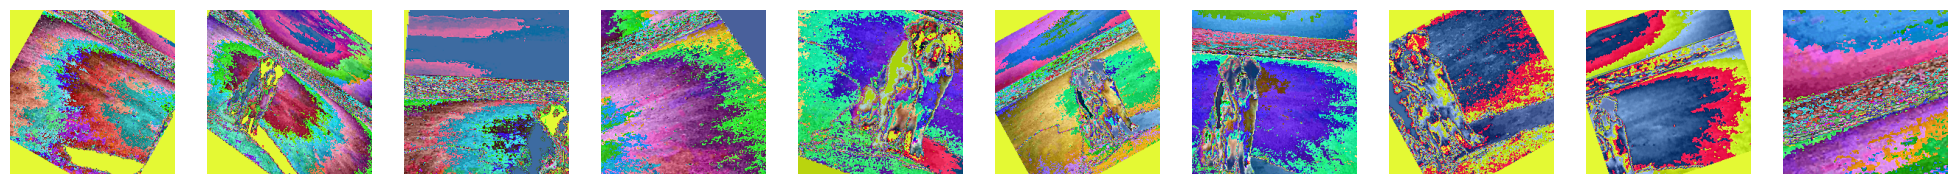

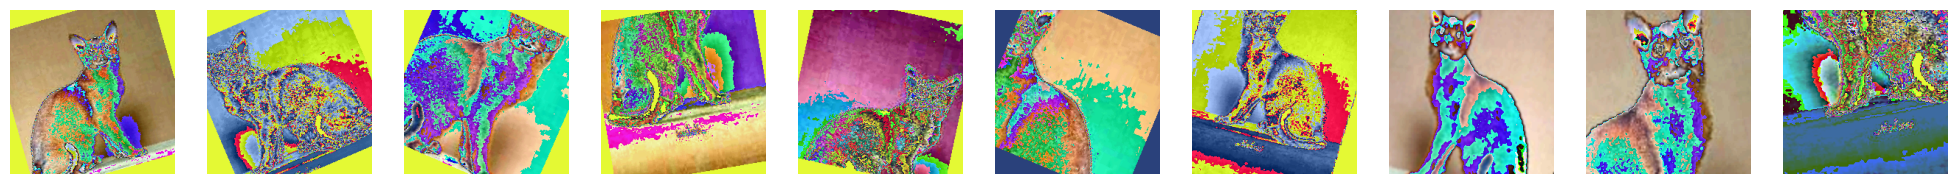

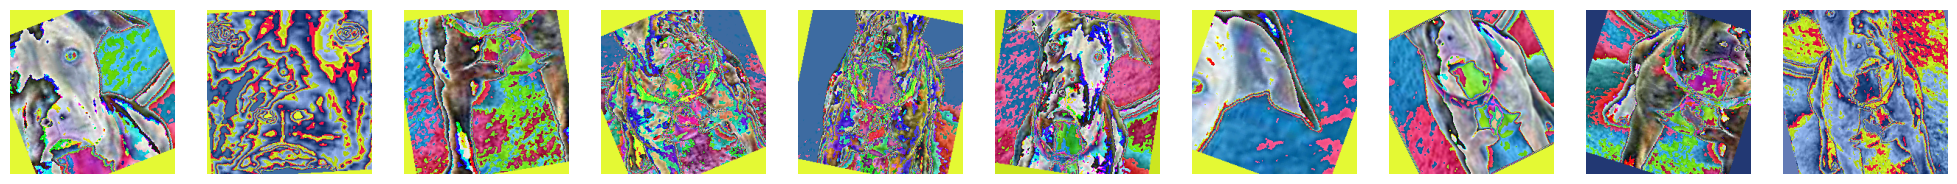

In [14]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomOrder([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.01, hue=0.01),
            transforms.RandomRotation(degrees=30),
            transforms.RandomGrayscale(p=0.3),
            # transforms.RandomApply([transforms.RandomAffine(0, translate=(0.1, 0.1)),], p=0.8),
            # transforms.RandomPerspective(distortion_scale=0.8, p=0.4, interpolation=3, fill=0),
            transforms.RandomApply([transforms.GaussianBlur((3, 3), (1.0, 2.0)),], p=0.1),
        ]),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in folders}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in folders}


# Preview the augmentations

import torchvision.transforms.functional as TF

def visualize_augmentations(dataset, idx=0, samples=10, use_transforms=None):
    """
    Given a Pytorch Dataset object, this will visualize a set of augmented images
    for the item at the provided index.
    """
    dataset = copy.deepcopy(dataset)  # we don't want to modify the actual dataset
    dataset.transform = use_transforms
    fig, axs = plt.subplots(1, samples, figsize=(samples * 2.5 , 2.5))
    for i in range(samples):
        img, label = dataset[idx]
        axs[i].imshow(TF.to_pil_image(img))
        axs[i].axis('off')
    plt.show()

# Use the training data transformations
use_transforms = data_transforms['train']

samples = 10  # number of samples to generate

# Note: Assuming 'image_datasets' is a dictionary containing 'train', 'val' and 'test' keys
# as in your initial code
visualize_augmentations(image_datasets['train'], 2400, samples, use_transforms)
visualize_augmentations(image_datasets['train'], 11, samples, use_transforms)
visualize_augmentations(image_datasets['train'], 1102, samples, use_transforms)

## Create Optimizer

In [15]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)


params_to_update = model_ft.parameters()
print("Params to learn:")
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)


# Define different sets of parameters (you may need to adjust this based on your model's architecture)
early_layers = list(model_ft.layer1.parameters()) + list(model_ft.layer2.parameters())
middle_layers = list(model_ft.layer3.parameters())
late_layers = list(model_ft.layer4.parameters()) + list(model_ft.fc.parameters())

# Define different learning rates
early_lr = 0.01
middle_lr = 0.05
late_lr = 0.1

# Create parameter groups
params_to_update = [{'params': early_layers, 'lr': early_lr},
                    {'params': middle_layers, 'lr': middle_lr},
                    {'params': late_layers, 'lr': late_lr}]

# Use the Adam optimizer
optimizer_ft = optim.AdamW(params_to_update)

# You can also define different learning rate schedulers for different layers if needed
# Here's an example with the CyclicLR scheduler
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer_ft, base_lr=0.01, max_lr=0.1, cycle_momentum=False)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

## Train the model

unfreezing: fc.weight
unfreezing: fc.bias
Epoch 1/20
----------
train Loss: 3.2733 Acc: 0.2965
val Loss: 0.9922 Acc: 0.6813


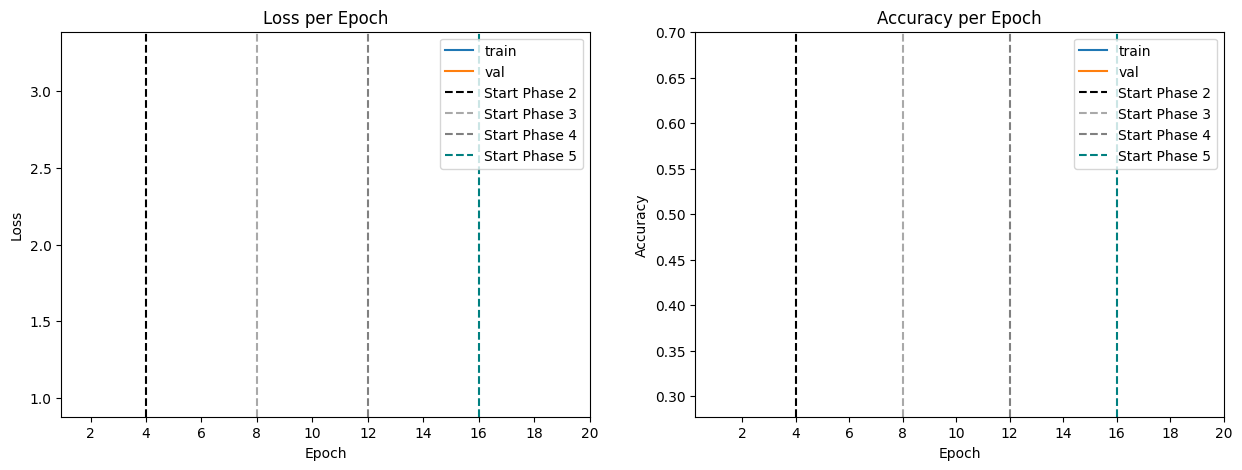


Epoch 2/20
----------
train Loss: 1.2716 Acc: 0.6318
val Loss: 0.4401 Acc: 0.8672


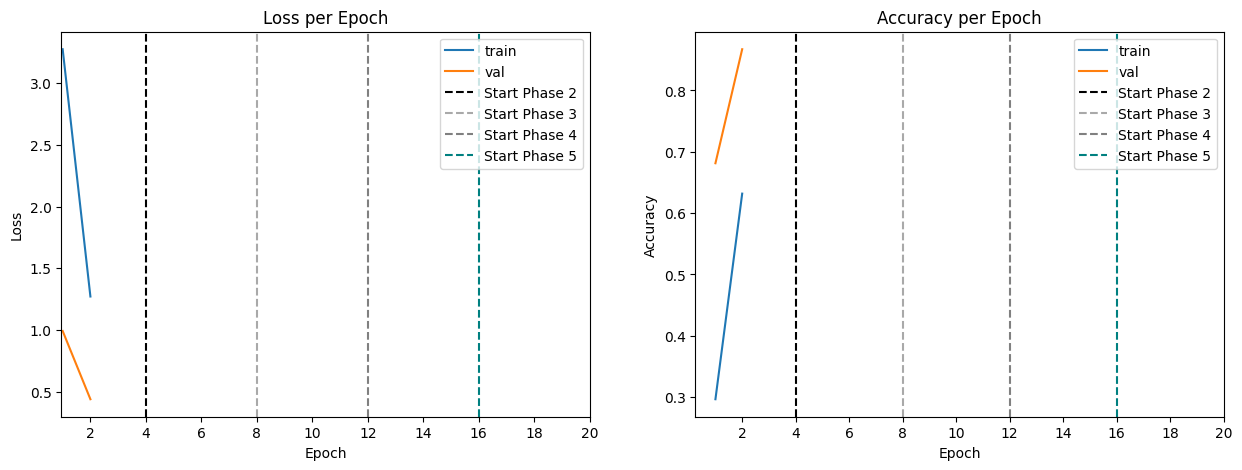


Epoch 3/20
----------
train Loss: 0.9450 Acc: 0.7266
val Loss: 0.3377 Acc: 0.8951


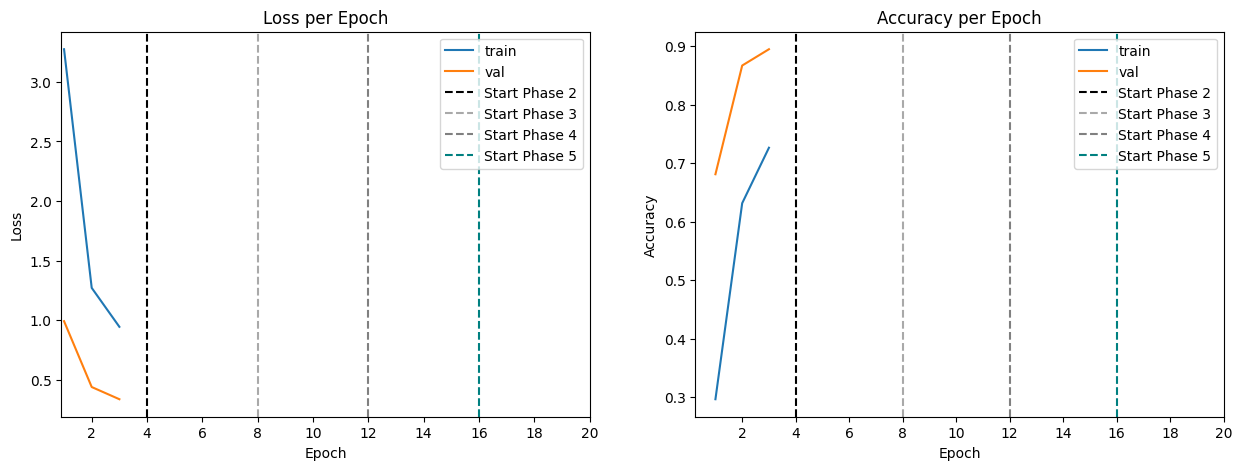


Epoch 4/20
----------
train Loss: 0.8420 Acc: 0.7518
val Loss: 0.3063 Acc: 0.9004


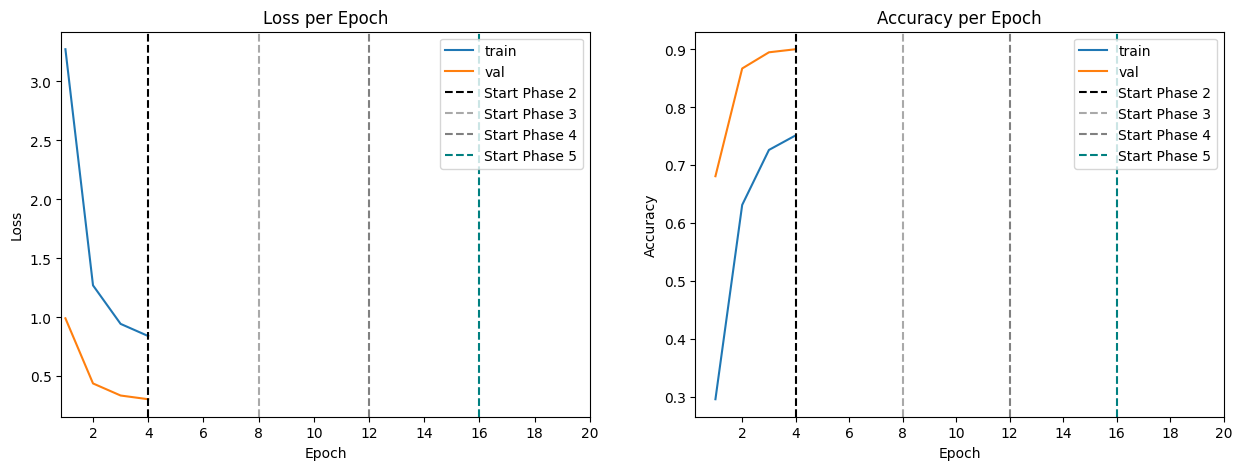


Epoch 5/20
----------
fine tuning starts!,  epoch == num_epochs // 5
unfreezing: layer4.2.conv1.weight
not unfreezing: layer4.2.bn1.weight
not unfreezing: layer4.2.bn1.bias
unfreezing: layer4.2.conv2.weight
not unfreezing: layer4.2.bn2.weight
not unfreezing: layer4.2.bn2.bias
unfreezing: layer4.2.conv3.weight
not unfreezing: layer4.2.bn3.weight
not unfreezing: layer4.2.bn3.bias
unfreezing: fc.weight
unfreezing: fc.bias
train Loss: 0.9039 Acc: 0.7212
val Loss: 0.8588 Acc: 0.7795


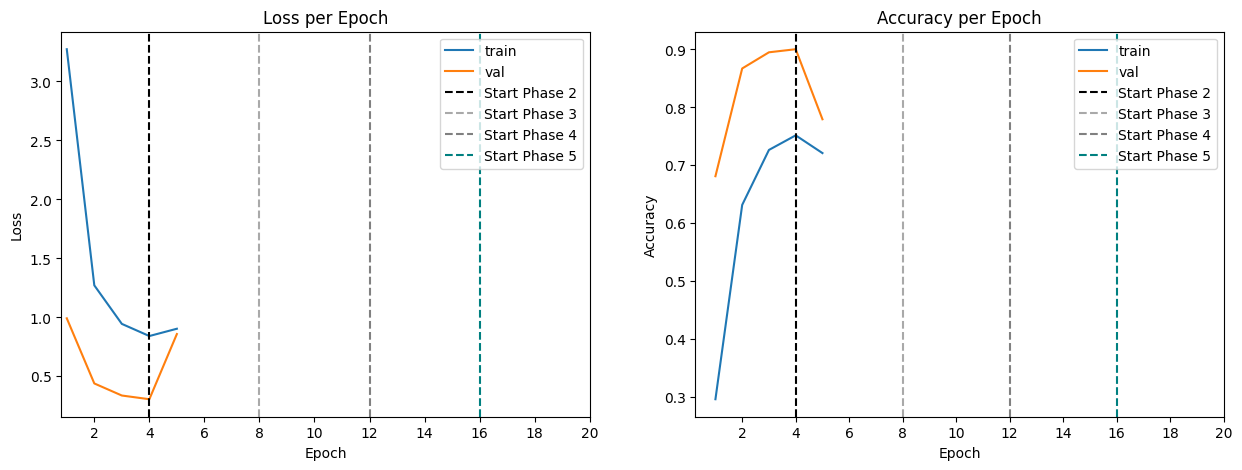


Epoch 6/20
----------
train Loss: 0.7441 Acc: 0.7650
val Loss: 0.3230 Acc: 0.8911


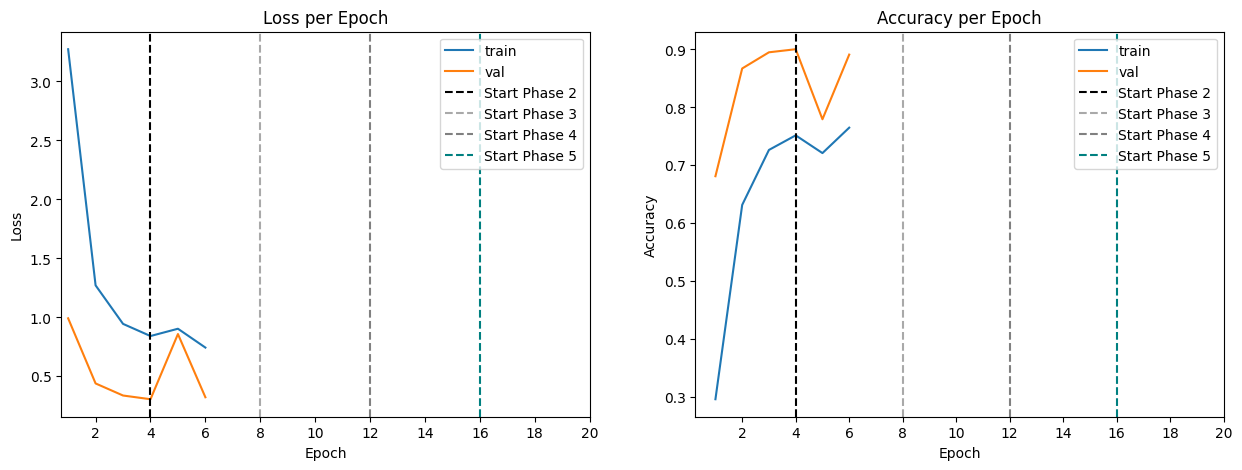


Epoch 7/20
----------
train Loss: 0.6815 Acc: 0.7936
val Loss: 0.2179 Acc: 0.9296


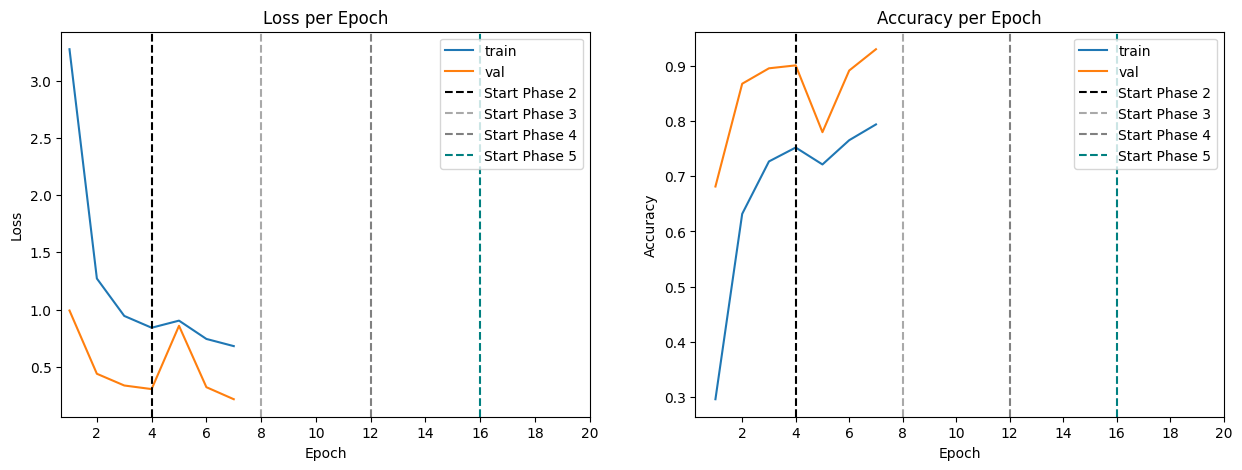


Epoch 8/20
----------
train Loss: 0.6660 Acc: 0.7916
val Loss: 0.2427 Acc: 0.9150


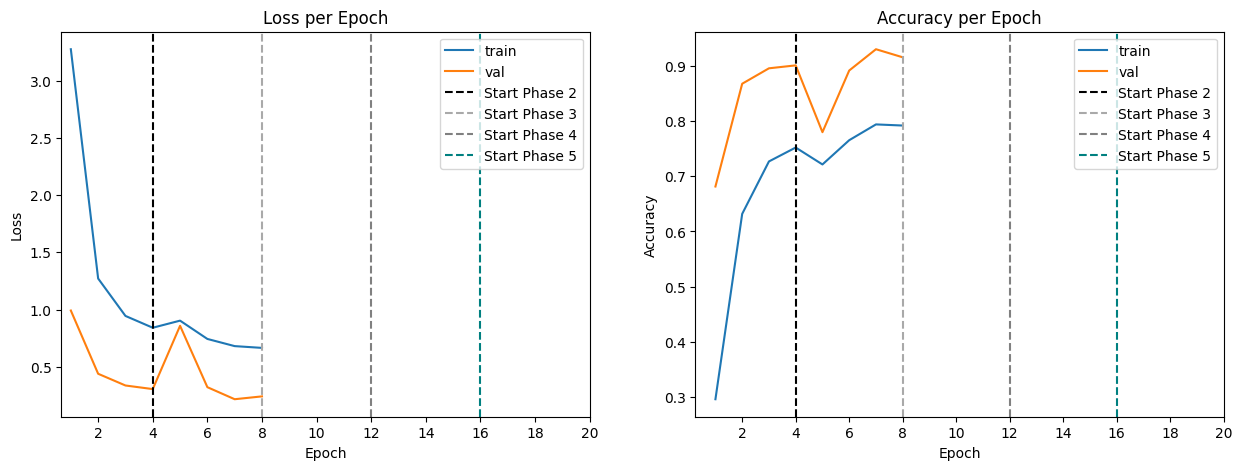


Epoch 9/20
----------
fine tuning starts!,  epoch == num_epochs * 2 // 5
unfreezing: layer3.0.conv1.weight
not unfreezing: layer3.0.bn1.weight
not unfreezing: layer3.0.bn1.bias
unfreezing: layer3.0.conv2.weight
not unfreezing: layer3.0.bn2.weight
not unfreezing: layer3.0.bn2.bias
unfreezing: layer3.0.conv3.weight
not unfreezing: layer3.0.bn3.weight
not unfreezing: layer3.0.bn3.bias
unfreezing: layer3.0.downsample.0.weight
unfreezing: layer3.0.downsample.1.weight
unfreezing: layer3.0.downsample.1.bias
unfreezing: layer4.0.conv1.weight
not unfreezing: layer4.0.bn1.weight
not unfreezing: layer4.0.bn1.bias
unfreezing: layer4.0.conv2.weight
not unfreezing: layer4.0.bn2.weight
not unfreezing: layer4.0.bn2.bias
unfreezing: layer4.0.conv3.weight
not unfreezing: layer4.0.bn3.weight
not unfreezing: layer4.0.bn3.bias
unfreezing: layer4.0.downsample.0.weight
unfreezing: layer4.0.downsample.1.weight
unfreezing: layer4.0.downsample.1.bias
unfreezing: layer4.1.conv1.weight
not unfreezing: layer4.1.b

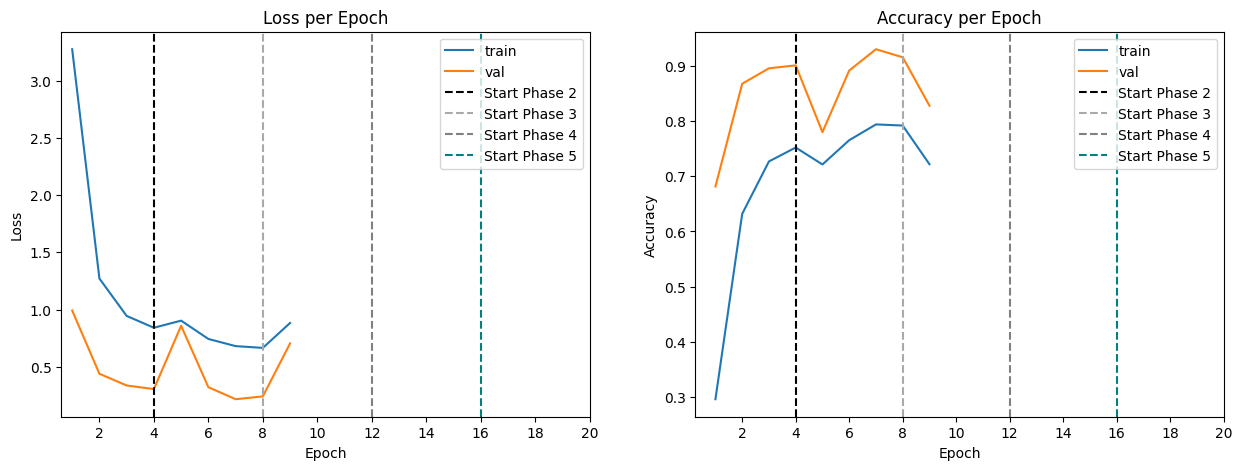


Epoch 10/20
----------
train Loss: 0.6134 Acc: 0.8028
val Loss: 0.3361 Acc: 0.8818


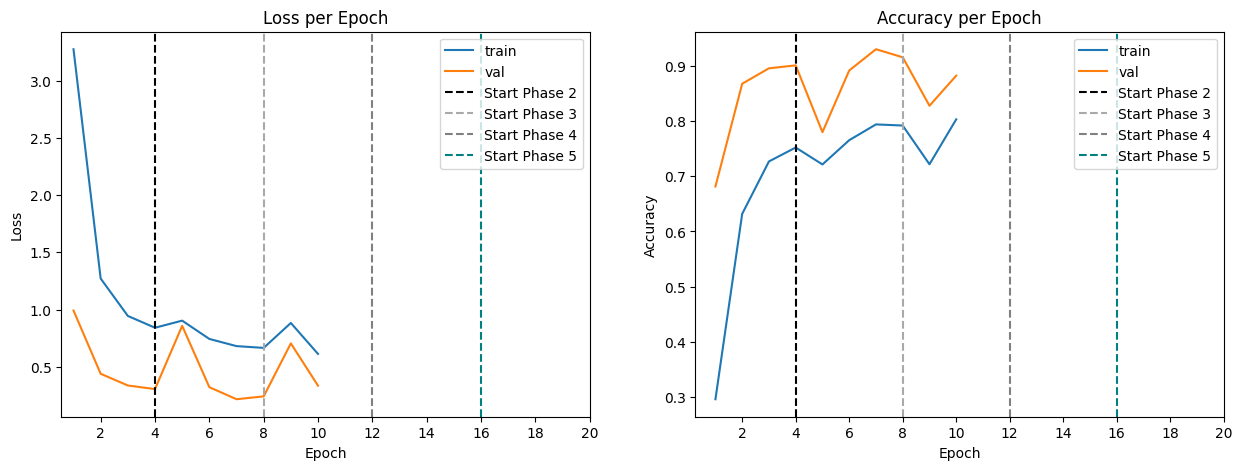


Epoch 11/20
----------
train Loss: 0.6129 Acc: 0.8041
val Loss: 0.2825 Acc: 0.9110


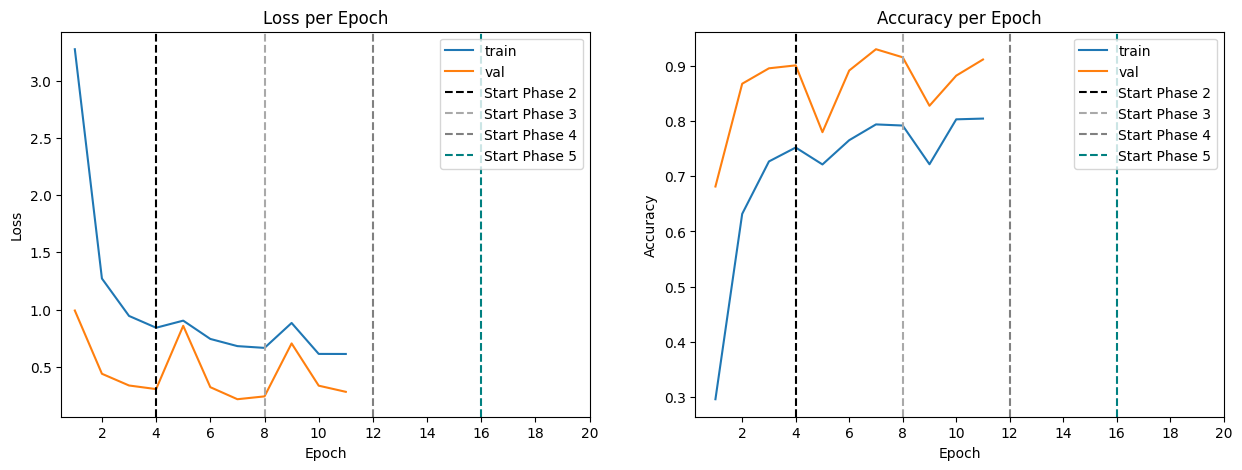


Epoch 12/20
----------
train Loss: 0.5474 Acc: 0.8310
val Loss: 0.2929 Acc: 0.8938


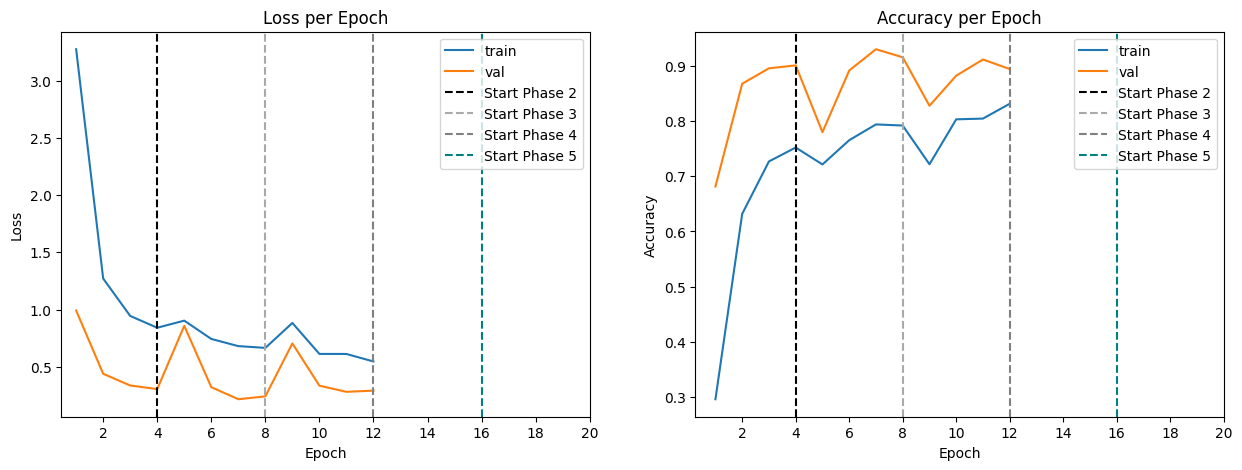


Epoch 13/20
----------
fine tuning starts!,  epoch == num_epochs * 3 // 5
unfreezing: layer2.0.conv1.weight
not unfreezing: layer2.0.bn1.weight
not unfreezing: layer2.0.bn1.bias
unfreezing: layer2.0.conv2.weight
not unfreezing: layer2.0.bn2.weight
not unfreezing: layer2.0.bn2.bias
unfreezing: layer2.0.conv3.weight
not unfreezing: layer2.0.bn3.weight
not unfreezing: layer2.0.bn3.bias
unfreezing: layer2.0.downsample.0.weight
unfreezing: layer2.0.downsample.1.weight
unfreezing: layer2.0.downsample.1.bias
unfreezing: layer2.1.conv1.weight
not unfreezing: layer2.1.bn1.weight
not unfreezing: layer2.1.bn1.bias
unfreezing: layer2.1.conv2.weight
not unfreezing: layer2.1.bn2.weight
not unfreezing: layer2.1.bn2.bias
unfreezing: layer2.1.conv3.weight
not unfreezing: layer2.1.bn3.weight
not unfreezing: layer2.1.bn3.bias
unfreezing: layer3.0.conv1.weight
not unfreezing: layer3.0.bn1.weight
not unfreezing: layer3.0.bn1.bias
unfreezing: layer3.0.conv2.weight
not unfreezing: layer3.0.bn2.weight
not un

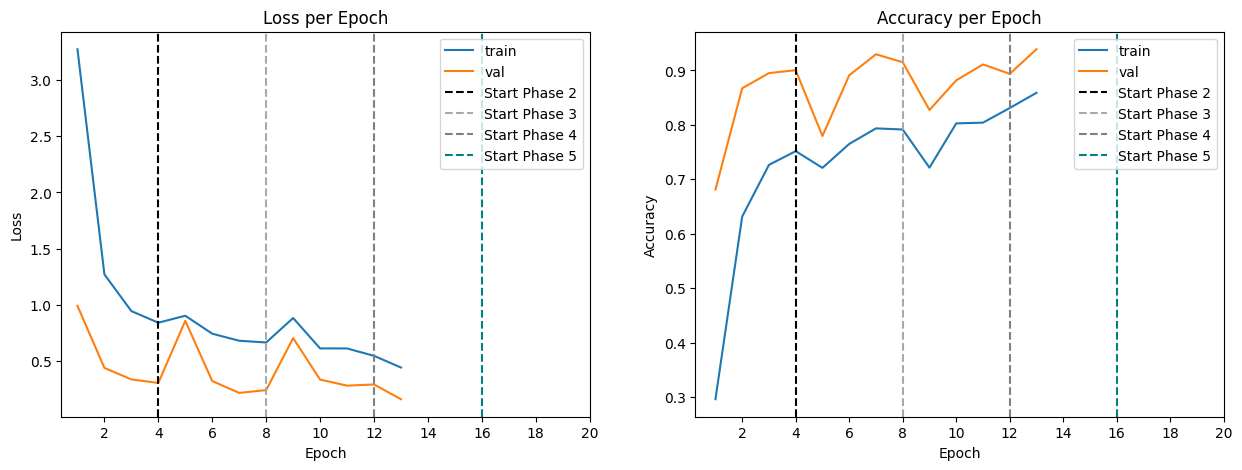


Epoch 14/20
----------
train Loss: 0.4232 Acc: 0.8660
val Loss: 0.1672 Acc: 0.9376


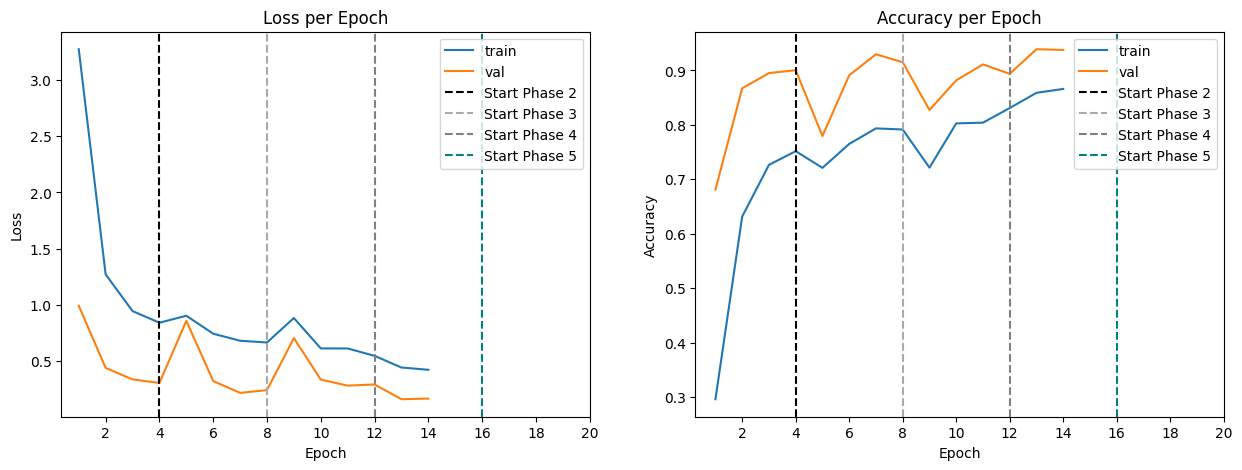


Epoch 15/20
----------
train Loss: 0.3800 Acc: 0.8800
val Loss: 0.1615 Acc: 0.9416


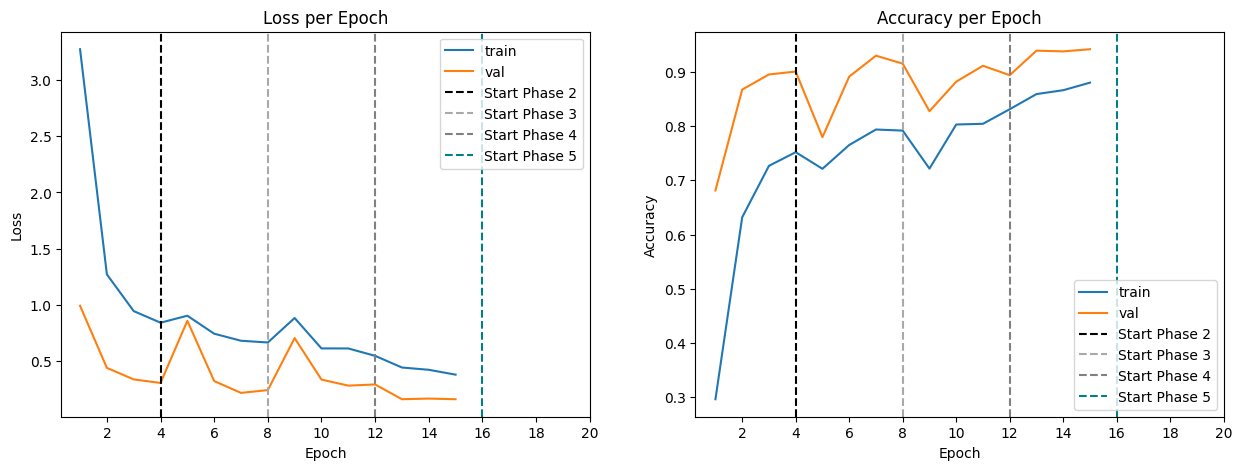


Epoch 16/20
----------
train Loss: 0.3545 Acc: 0.8909
val Loss: 0.1652 Acc: 0.9416


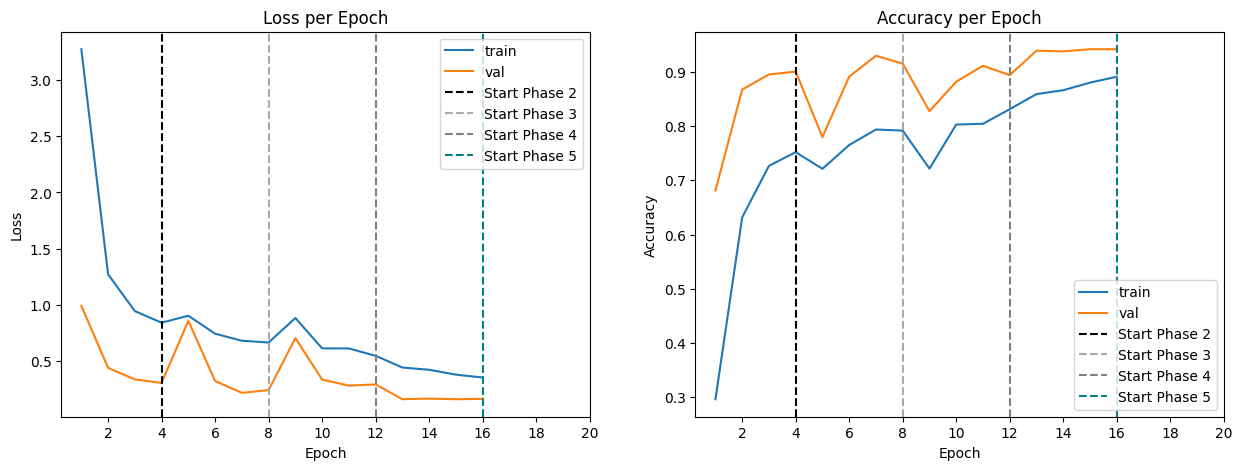


Epoch 17/20
----------
fine tuning starts!,  epoch == num_epochs * 4 // 5
unfreezing: layer1.0.conv1.weight
not unfreezing: layer1.0.bn1.weight
not unfreezing: layer1.0.bn1.bias
unfreezing: layer1.0.conv2.weight
not unfreezing: layer1.0.bn2.weight
not unfreezing: layer1.0.bn2.bias
unfreezing: layer1.0.conv3.weight
not unfreezing: layer1.0.bn3.weight
not unfreezing: layer1.0.bn3.bias
unfreezing: layer1.0.downsample.0.weight
unfreezing: layer1.0.downsample.1.weight
unfreezing: layer1.0.downsample.1.bias
unfreezing: layer2.0.conv1.weight
not unfreezing: layer2.0.bn1.weight
not unfreezing: layer2.0.bn1.bias
unfreezing: layer2.0.conv2.weight
not unfreezing: layer2.0.bn2.weight
not unfreezing: layer2.0.bn2.bias
unfreezing: layer2.0.conv3.weight
not unfreezing: layer2.0.bn3.weight
not unfreezing: layer2.0.bn3.bias
unfreezing: layer2.0.downsample.0.weight
unfreezing: layer2.0.downsample.1.weight
unfreezing: layer2.0.downsample.1.bias
unfreezing: layer2.1.conv1.weight
not unfreezing: layer2.1.

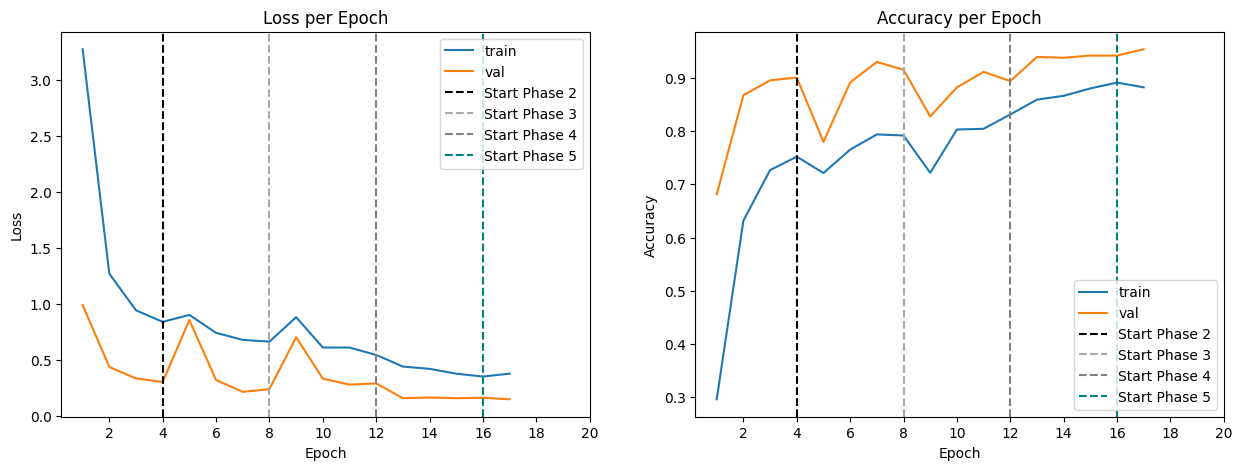


Epoch 18/20
----------
train Loss: 0.3155 Acc: 0.9041
val Loss: 0.1410 Acc: 0.9575


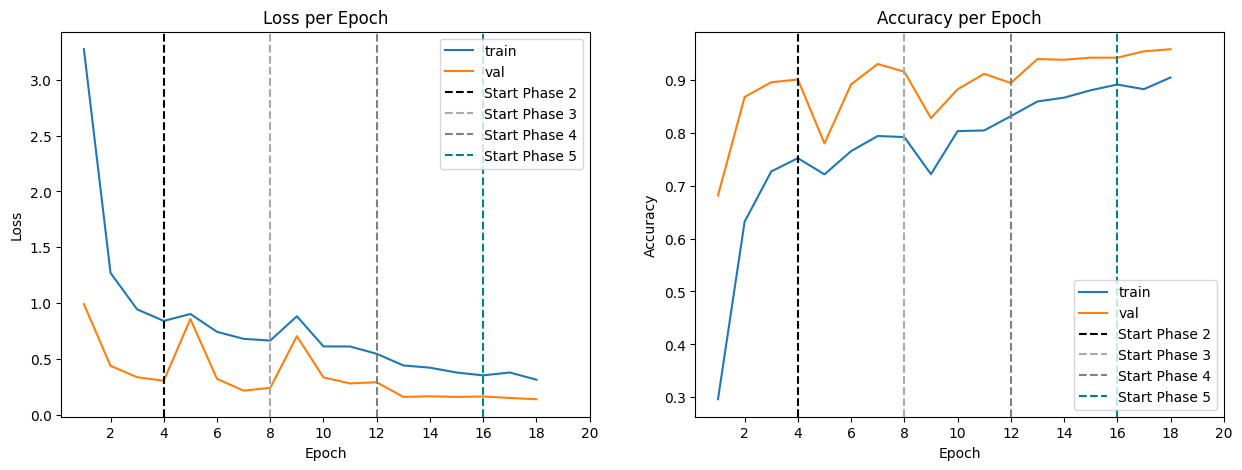


Epoch 19/20
----------
train Loss: 0.3181 Acc: 0.8994
val Loss: 0.1480 Acc: 0.9522


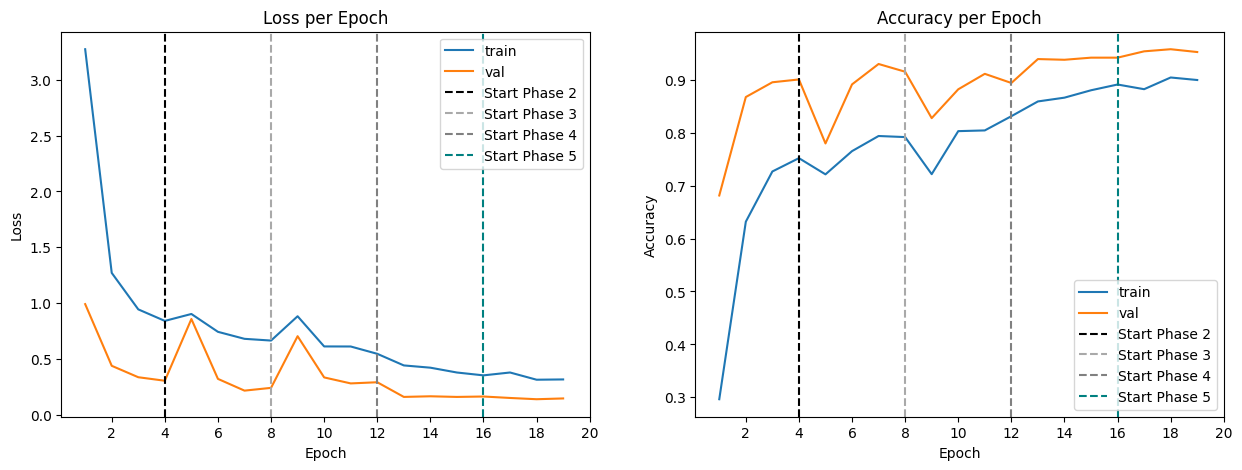


Epoch 20/20
----------
train Loss: 0.3016 Acc: 0.9048
val Loss: 0.1459 Acc: 0.9495


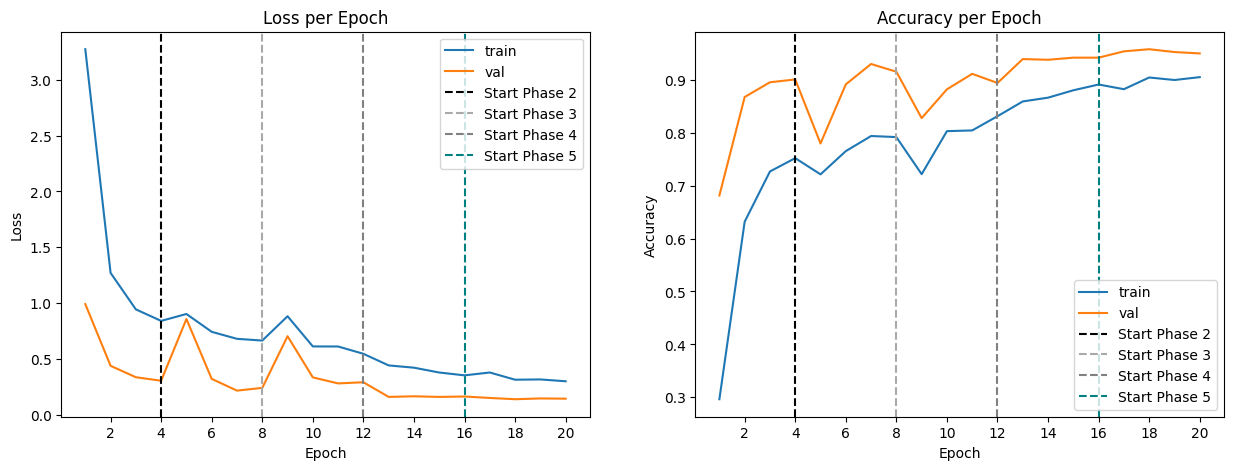


Training complete in 59m 50s
Best val Acc: 0.957503


In [16]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

## Test the model

In [17]:
test_model(model_ft, dataloaders_dict, criterion)


Testing the model
----------
test Loss: 0.2304 Acc: 0.9290
